# MODULES

In [1]:
!pip install pathlib
!pip install matplotlib

In [2]:
!nvidia-smi

Sat Sep  6 20:13:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX330           Off |   00000000:2C:00.0 Off |                  N/A |
| N/A   52C    P8            N/A  / 5001W |       5MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

1.13.1+cu117
11.7
NVIDIA GeForce MX330


In [4]:
import os
import cv2
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# GLOBAL VARIABLES

In [5]:
ROOT_DIR_IMAGES = '../SampleSet/MVS Data/Cleaned/scan6'

# IMAGES

In [6]:
class ImageMisc:
    @classmethod
    def get_paths(cls, root_dir, filter):
        paths = []
        for path in pathlib.Path(root_dir).glob(filter):
            paths.append(str(path))
        paths = sorted(paths)
        return paths
    
    @classmethod
    def load_images(cls, paths):
        images = []
        for path in paths:
            img_bgr = cv2.imread(path)          # Load as BGR
            if img_bgr is None:
                continue  # skip if image not found or unreadable
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img_rgb)
        return images

    @classmethod
    def to_grayscale(cls, image):
        if image.ndim == 2:  # already grayscale
            return image
        else:  # RGB to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            return gray

In [45]:
class _Image:
    def set_imag(self, imag):
        self.imag = imag
        return self

    def set_imag_gray(self, imag_gray):
        self.imag_gray = imag_gray
        return self

    def set_kpts_dess(self, kpts, dess):
        self.kpts = kpts
        self.dess = dess
        return self

    def compute_imag_with_kpts(self, circle_color=(0, 255, 0), circle_thickness=2, line_thickness=2):
        imag = self.imag.copy()

        for kpt in self.kpts:
            x, y = int(kpt.pt[0]), int(kpt.pt[1])
            radius = int(kpt.size / 2)
    
            # Draw circle
            cv2.circle(imag, (x, y), radius, circle_color, thickness=circle_thickness)
    
            # Draw orientation line
            angle_rad = math.radians(kpt.angle)
            x2 = int(x + radius * math.cos(angle_rad))
            y2 = int(y + radius * math.sin(angle_rad))
            cv2.line(img, (x, y), (x2, y2), circle_color, thickness=line_thickness)
    
        self.imag_kpts = imag
        return self.im

    
class ImageData(_Image):
    def __init__(self):
        self.imag = None
        self.imag_gray = None
        self.kpts = None
        self.dess = None
        self.imag_kpts = None


In [31]:
class Plot:
    @classmethod    
    def plot_images_grid(cls, images, nrows=1, ncols=1, figsize=(12, 8)):
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        axes = axes.flatten()  # make it 1D for easy iteration

        for ax, img in zip(axes, images):
            if img.ndim == 2:  # grayscale
                ax.imshow(img, cmap="gray")
            else:  # RGB
                ax.imshow(img)
            ax.axis("off")

        for ax in axes[len(images):]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

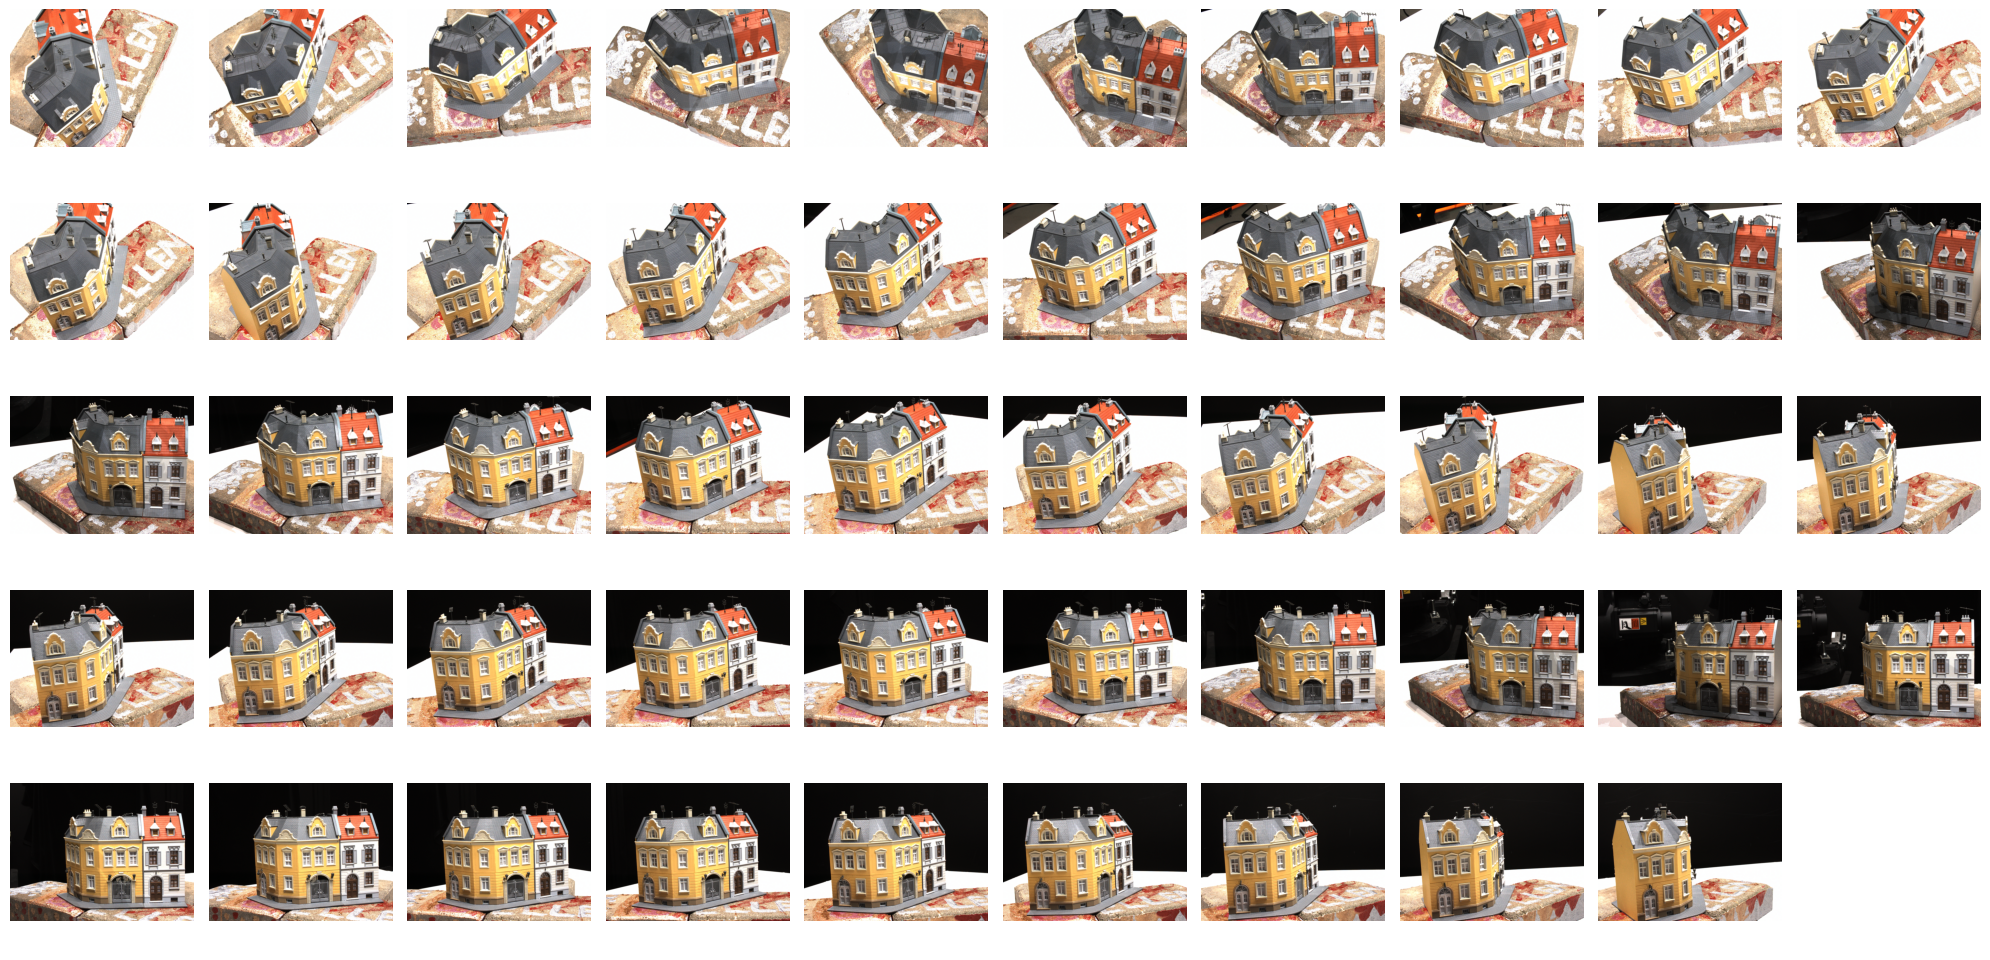

In [32]:
paths = ImageMisc.get_paths(ROOT_DIR_IMAGES, '*max.png')
imags = ImageMisc.load_images(paths)
Plot.plot_images_grid(imags, 5,10, (20,10))

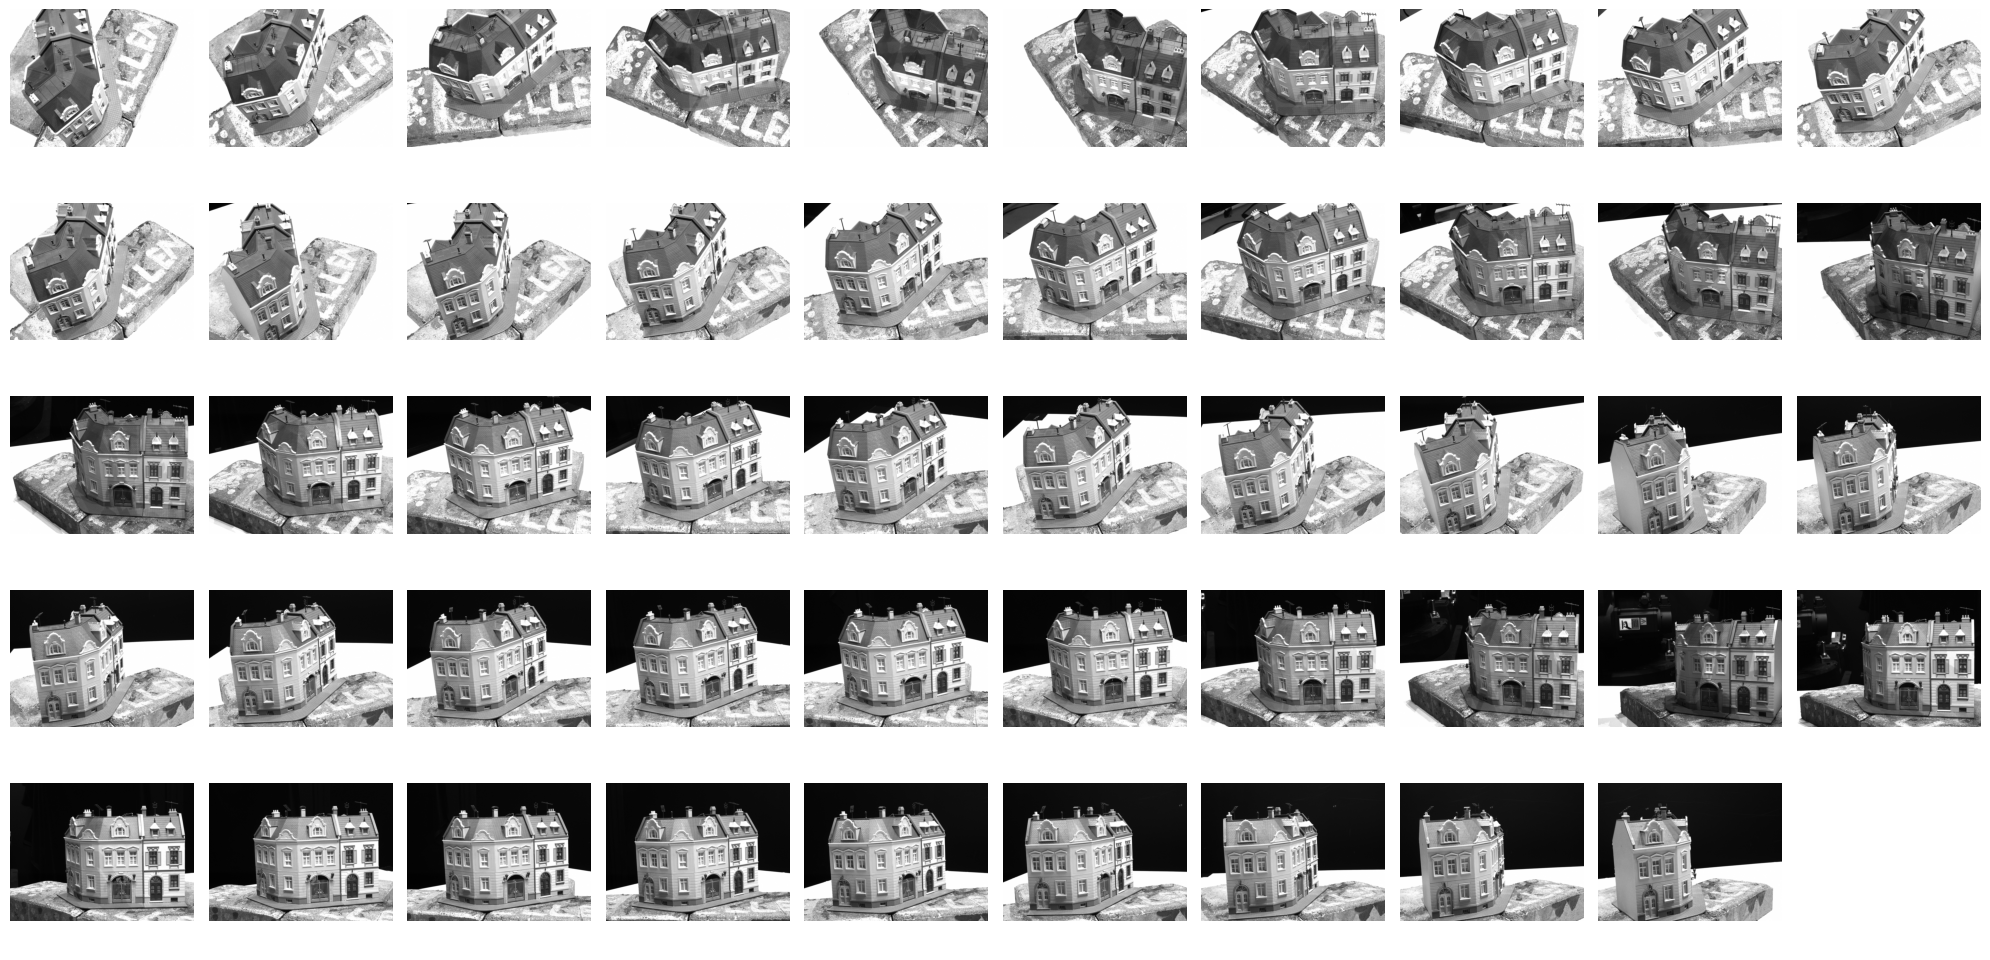

In [33]:
imags_gray = list(map(ImageMisc.to_grayscale, imags))
Plot.plot_images_grid(imags_gray, 5,10, (20,10))


# FEATURE DETECTOR

In [37]:
class FeatureDetector:
  def __init__(self, kind):
      allowed = ['sift', 'orb']
      if kind not in allowed:
        raise ValueError(f"Unsupported feature detector: {kind}. Allowed: {allowed}")

      if kind == 'sift':
        self.detector = cv2.SIFT_create()
      elif kind == 'orb':
        self.detector = cv2.ORB_create()


  def detect(self, image_gray):
      kpts, dess = self.detector.detectAndCompute(image_gray, None)
      return kpts, dess

In [40]:
FD = FeatureDetector(kind='sift')
IDS = []
for imag, imag_gray in zip(imags, imags_gray):
    kpts, dess = FD.detect(imag_gray)
    ID = ImageData().set_imag(imag).set_imag_gray(imag_gray).set_kpts_dess(kpts, dess)
    IDS.append(ID)
    